# Random Forest Simulation

### Data preparation

In [159]:
import numpy as np
import pandas as pd 
import sys
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")

# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')
elo_ratings = pd.read_csv("/Users/JISOO/Desktop/STAT3011-Group5-Project2/elo rating.csv")



In [160]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])

# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'


Confusion matrix:
 [[1229  679]
 [ 687 1101]]
Classification report:
               precision    recall  f1-score   support

       False       0.64      0.64      0.64      1908
        True       0.62      0.62      0.62      1788

    accuracy                           0.63      3696
   macro avg       0.63      0.63      0.63      3696
weighted avg       0.63      0.63      0.63      3696

Accuracy: 0.6304112554112554
ROC AUC score: 0.6787022673870529


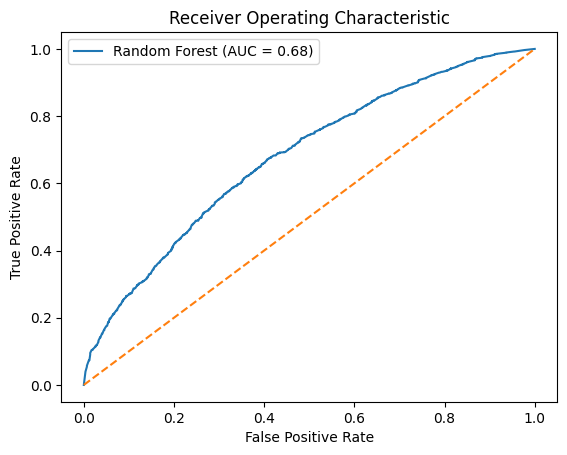

In [161]:
# Create the feature matrix X and the target vector y
X, y = matches.loc[:, ['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.set_params(**{'n_jobs':-1})

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Compute the classification report
cr = classification_report(y_test, y_pred)
print("Classification report:\n", cr)

# Compute the accuracy of the classifier
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Compute the ROC AUC score and plot the ROC curve
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print("ROC AUC score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Stakes distribution in the wrong predictions
True     0.566618
False    0.433382
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


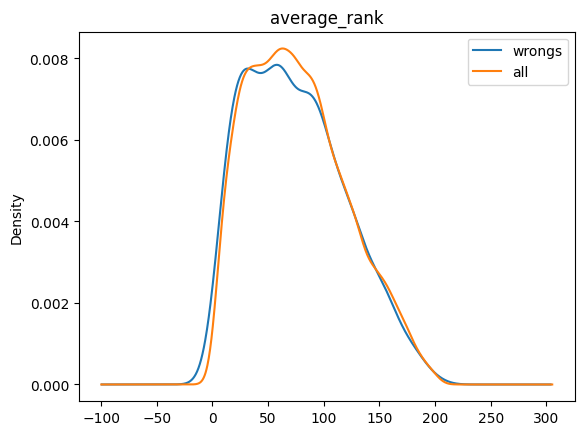

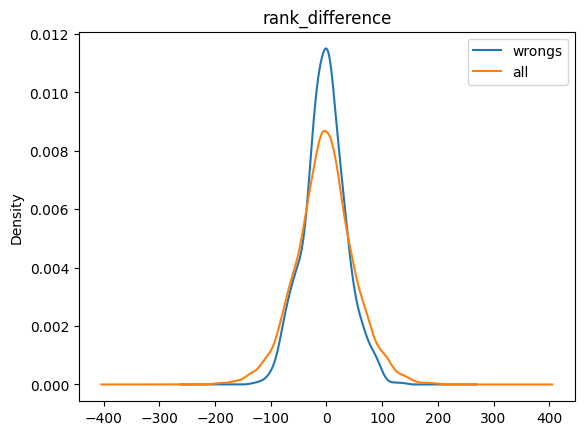

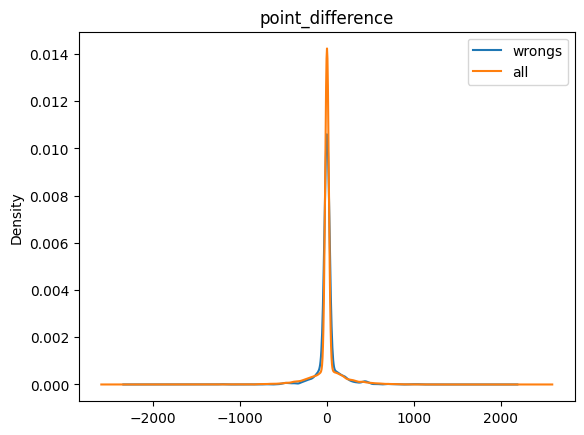

In [162]:
features = ['average_rank', 'rank_difference', 'point_difference']

# Get the wrongly predicted matches
wrongs = y_test != rfc.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [163]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [164]:
world_cup

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran
Spain,B,Portugal,Iran,Morocco
Morocco,B,Iran,Portugal,Spain
Iran,B,Morocco,Spain,Portugal
France,C,Australia,Peru,Denmark


In [165]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # get the prediction proability of the home team winning
        home_win_prob = rfc.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group H:___
Poland vs. Senegal: Senegal wins with 0.71
Poland vs. Colombia: Colombia wins with 0.59
Poland vs. Japan: Poland wins with 0.73
Senegal vs. Colombia: Colombia wins with 0.75
Senegal vs. Japan: Senegal wins with 0.67
Colombia vs. Japan: Colombia wins with 0.72
___Starting group B:___
Portugal vs. Spain: Portugal wins with 0.56
Portugal vs. Morocco: Portugal wins with 0.66
Portugal vs. Iran: Portugal wins with 0.57
Spain vs. Morocco: Spain wins with 0.54
Spain vs. Iran: Spain wins with 0.59
Morocco vs. Iran: Iran wins with 0.82
___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.79
Belgium vs. Tunisia: Belgium wins with 0.68
Belgium vs. England: England wins with 0.79
Panama vs. Tunisia: Tunisia wins with 0.91
Panama vs. England: England wins with 0.81
Tunisia vs. England: England wins with 0.58
___Starting group A:___
Russia vs. Saudi Arabia: Draw
Russia vs. Egypt: Egypt wins with 0.74
Russia vs. Uruguay: Uruguay wins with 0.59
Saudi Arabia vs. Egypt:

In [166]:
world_cup

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay,1,1.181667
Saudi Arabia,A,Russia,Uruguay,Egypt,1,0.996667
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.571667
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.250000
Portugal,B,Spain,Morocco,Iran,9,1.790000
Spain,B,Portugal,Iran,Morocco,6,1.570000
Morocco,B,Iran,Portugal,Spain,0,0.980000
Iran,B,Morocco,Spain,Portugal,3,1.660000
France,C,Australia,Peru,Denmark,7,2.020000


In [167]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.250000
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.571667
Spain,B,Portugal,Iran,Morocco,6,1.570000
Portugal,B,Spain,Morocco,Iran,9,1.790000
France,C,Australia,Peru,Denmark,7,2.020000
Denmark,C,Peru,Australia,France,7,1.930000
Croatia,D,Nigeria,Argentina,Iceland,4,1.520833
Iceland,D,Argentina,Nigeria,Croatia,7,1.839167
Brazil,E,Switzerland,Costa Rica,Serbia,9,1.991667


In [168]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = rfc.predict_proba(row)[:,1][0]
        
        # Display resultes
        if rfc.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.56
France vs. Croatia: Croatia wins with probability 0.68
Brazil vs. Sweden: Sweden wins with probability 0.64
England vs. Senegal: England wins with probability 0.57
Egypt vs. Portugal: Portugal wins with probability 0.67
Denmark vs. Iceland: Denmark wins with probability 0.69
Costa Rica vs. Mexico: Mexico wins with probability 0.83
Belgium vs. Colombia: Colombia wins with probability 0.59


___Starting of the quarterfinal___
Spain vs. Croatia: Croatia wins with probability 0.68
Sweden vs. England: England wins with probability 0.88
Portugal vs. Denmark: Denmark wins with probability 0.84
Mexico vs. Colombia: Mexico wins with probability 0.71


___Starting of the semifinal___
Croatia vs. England: England wins with probability 0.84
Denmark vs. Mexico: Denmark wins with probability 0.61


___Starting of the final___
England vs. Denmark: England wins with probability 0.71




/var/folders/hm/f_2f7w212174qh26d8_r_npc0000gn/T/ipykernel_41939/3678938229.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


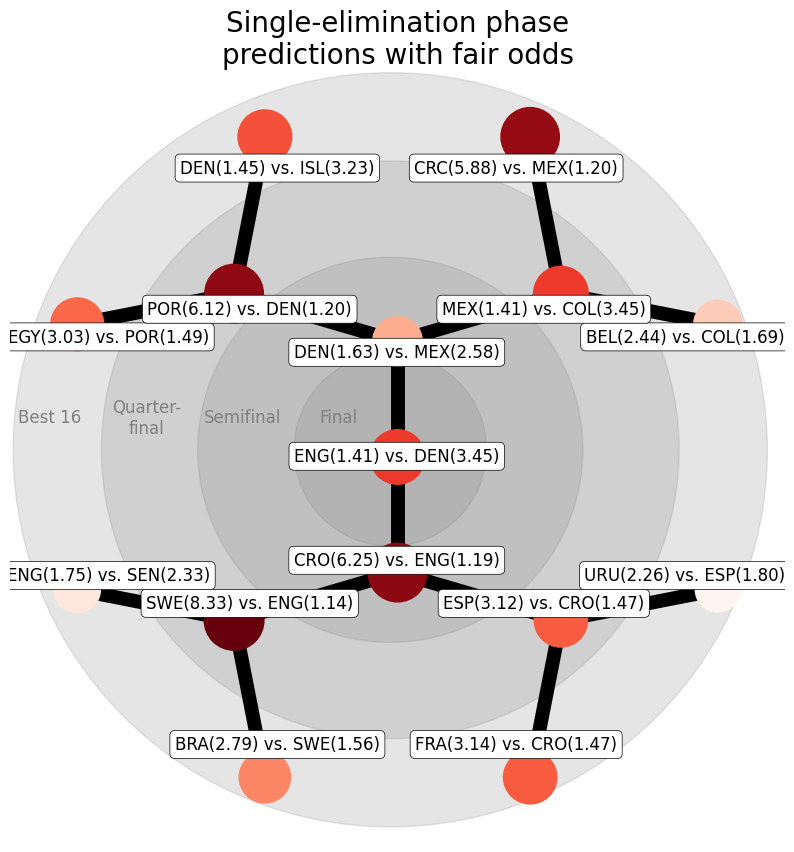

In [169]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()
